In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

import glob
import random
import datetime
import tensorflow as tf
import numpy as np
import sklearn as sk
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import  Lambda, Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from shutil import rmtree
from keras.models import load_model
from os.path import join, getctime, basename
from models import *
from utils import *
from data_preprocess import load_prep_data

%load_ext autoreload
%autoreload 2

aug_data = load_prep_data(time=500, debug=True, pooling = True, subsample = 2, average = 2, normalization = False, noise_level = 0.5)
x_train = aug_data['x_train']
y_train = aug_data['y_train']
x_valid = aug_data['x_valid']
y_valid = aug_data['y_valid']
x_test = aug_data['x_test']
y_test = aug_data['y_test']

x_train = tf.transpose(x_train, perm=[0, 2, 1])
x_valid = tf.transpose(x_valid, perm=[0, 2, 1])
x_test = tf.transpose(x_test, perm=[0, 2, 1])

print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of x_train set: (7191, 22, 250)
Shape of y_train labels: (7191, 4)
Shape of x_valid set: (1269, 22, 250)
Shape of y_valid labels: (1269, 4)
Shape of x_test set: (1772, 22, 250)
Shape of y_test labels: (1772, 4)
Shape of x_train_valid set: (8460, 22, 250)
Shape of y_train_valid labels: (8460, 4)
Shape of training set after dimension reshaping: (7191, 250, 22)
Shape of validation set after dimension reshaping: (1269, 250, 22)
Shape of test set after dimension reshaping: (1772, 250, 22)


In [3]:
# from https://keras.io/examples/generative/vae/
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# from https://keras.io/examples/generative/vae/
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.accuracy_tracker = keras.metrics.Accuracy(name = 'accuracy')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            #self.accuracy_tracker        
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(tf.reshape(data, (-1, 22)), tf.reshape(reconstruction, (-1, 22)))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var + 1e-7))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            #accuracy = self.accuracy_tracker.result()
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.accuracy_tracker().update_state(accuracy)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"accuracy":self.accuracy_tracker.result()
        }

In [5]:
latent_dim = 10
vae_filts1 = 100

## Build Encoder with GRU
encoder_inputs = keras.Input(shape=(250, 22))
x = layers.Conv1D(vae_filts1, 10, strides=2, activation="relu", padding='same')(encoder_inputs)
x = layers.GRU(64, return_sequences=False)(x)  # Adjust GRU output based on the need
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_log_var += 1e-8  # Ensure numerical stability
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

## Build the decoder with GRU
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64 * 250, activation="relu")(latent_inputs)  # Adjusted for GRU input
x = layers.Reshape((250, 64))(x)  # Adjust shape for GRU input
x = layers.GRU(64, return_sequences=True)(x)
x = layers.TimeDistributed(layers.Dense(22))(x)  # TimeDistributed wrapper for output

decoder = keras.Model(latent_inputs, x, name="decoder")
decoder.summary()

vae = VAE(encoder, decoder)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 22)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 125, 100)             22100     ['input_1[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 64)                   31872     ['conv1d[0][0]']              
                                                                                                  
 dense (Dense)               (None, 16)                   1040      ['gru[0][0]']                 
                                                                                            

In [6]:
learning_rate = 1e-3
decay = 1e-6
vae_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay = decay, clipvalue=0.5)
vae.compile(optimizer=vae_optimizer)

print("x_train.shape {}".format(x_train.shape))
vae.fit(x_train, epochs = 30, batch_size=128, verbose = True)

x_train.shape (7191, 250, 22)
Epoch 1/30
57/57 [==============================] - 13s 203ms/step - loss: 4.2556 - reconstruction_loss: 0.9647 - kl_loss: 0.4325
Epoch 2/30
57/57 [==============================] - 12s 202ms/step - loss: -4.9243 - reconstruction_loss: -9.0942 - kl_loss: 0.4774
Epoch 3/30
57/57 [==============================] - 12s 206ms/step - loss: -19.9130 - reconstruction_loss: -21.2769 - kl_loss: 0.4930
Epoch 4/30
57/57 [==============================] - 13s 220ms/step - loss: -21.9153 - reconstruction_loss: -22.6451 - kl_loss: 0.2884
Epoch 5/30
57/57 [==============================] - 12s 219ms/step - loss: -23.0624 - reconstruction_loss: -23.3642 - kl_loss: 0.5601
Epoch 6/30
57/57 [==============================] - 12s 210ms/step - loss: -23.5361 - reconstruction_loss: -24.6034 - kl_loss: 0.7011
Epoch 7/30
57/57 [==============================] - 12s 208ms/step - loss: -24.0234 - reconstruction_loss: -24.7767 - kl_loss: 0.7387
Epoch 8/30
57/57 [====================

In [7]:
#Passing real data through VAE to generate "fake" data
z_sample = vae.encoder([x_train])[2]
x_decoded = vae.decoder([z_sample])

Before VAE


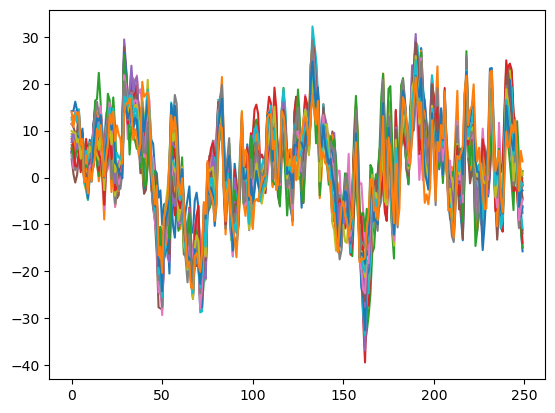

After VAE:


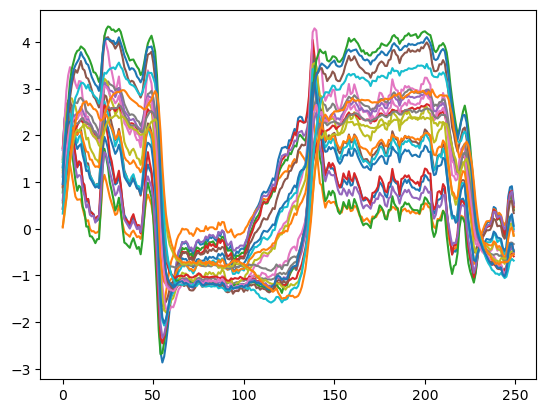

x_train3.shape (14382, 250, 22) y_train3.shape (14382, 4)


In [8]:
# print(x_train)
x_tane = tf.reshape(x_train, (x_train.shape[0], 250, 22))
print('Before VAE')
plt.plot(x_tane[7])
plt.show()

print('After VAE:')
x_vae = np.array(x_decoded).reshape(x_decoded.shape[0], 250, 22)
plt.plot(x_vae[1])
plt.show()

#Adding fake image data to existing real data
x_train3 = np.concatenate((x_train, x_decoded), axis = 0)
y_train3 = np.concatenate((y_train, y_train), axis = 0)
print("x_train3.shape {} y_train3.shape {}".format(x_train3.shape, y_train3.shape))

In [15]:
x_train_transposed = tf.transpose(tf.expand_dims(x_train3, axis=-1), perm=[0, 1, 3, 2])
x_valid_transposed = tf.transpose(tf.expand_dims(x_valid, axis=-1), perm=[0, 1, 3, 2])
x_test_transposed = tf.transpose(tf.expand_dims(x_test, axis=-1), perm=[0, 1, 3, 2])

input_shape = x_train_transposed.shape
print("x_train_transposed.shape: {}", format(x_train_transposed.shape))

config = {
    # Network
    'num_inputs': input_shape[0],
    'input_shape': (input_shape[1], 1, input_shape[3]), # (250, 1, 22)
    'epochs': 100,
    'dropout': 0.5,
    'batch_size': 64
}
model = CNN4LayerGRU()
model.build_model(config)
history = model.train(x_train_transposed, y_train3, x_valid_transposed, y_valid, config, get_workpath('CNN4LayerGRU'))

raw = model.evaluate(x_test_transposed, y_test)
print("Raw Acc result: {}".format(raw[1]))

x_train_transposed.shape: {} (14382, 250, 1, 22)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 250, 1, 25)        13775     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 84, 1, 25)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 84, 1, 25)         100       
 tchNormalization)                                               
                                                                 
 dropout_36 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 84, 1, 50)         31300     
                                                                 
 max_

In [16]:
x_train_transposed = tf.transpose(tf.expand_dims(x_train, axis=-1), perm=[0, 1, 3, 2])
x_valid_transposed = tf.transpose(tf.expand_dims(x_valid, axis=-1), perm=[0, 1, 3, 2])
x_test_transposed = tf.transpose(tf.expand_dims(x_test, axis=-1), perm=[0, 1, 3, 2])

input_shape = x_train_transposed.shape
print("x_train_transposed.shape: {}", format(x_train_transposed.shape))

config = {
    # Network
    'num_inputs': input_shape[0],
    'input_shape': (input_shape[1], 1, input_shape[3]), # (250, 1, 22)
    'epochs': 100,
    'dropout': 0.5,
    'batch_size': 64
}
model = CNN4LayerGRU()
model.build_model(config)
history = model.train(x_train_transposed, y_train, x_valid_transposed, y_valid, config, get_workpath('CNN4LayerGRU'))

raw = model.evaluate(x_test_transposed, y_test)
print("Raw Acc result: {}".format(raw[1]))

x_train_transposed.shape: {} (7191, 250, 1, 22)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 250, 1, 25)        13775     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 84, 1, 25)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_28 (Ba  (None, 84, 1, 25)         100       
 tchNormalization)                                               
                                                                 
 dropout_42 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 84, 1, 50)         31300     
                                                                 
 max_p